## Basic classifier that uses Distilbert model to predict if the payload is an SQL injection
##### Distilbert is a smaller and faster version of BERT ( Bidirectional Encoder Representations from Transformers) that is 40% lighter while retaining 97% of BERT's language understanding ability. More on Distilbert at [HuggingFace](https://huggingface.co/docs/transformers/model_doc/distilbert)

### To begin, let's install and import some packages


In [1]:
!pip3 install scikit-learn>=1.0.0
!pip3 install ktrain matplotlib tensorflow numpy
import matplotlib
import os
import numpy as np
%reload_ext autoreload
%autoreload 2
%matplotlib inline
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


#### Some more imports...We are using ktrain wrapper to simplify model operations and take advantage of some cool stuff like simplified data set preprocessing, learning rate finding and "autofit" that ensures the model is not overfit. More details on ktrain here: [ktrain on GitHub](https://github.com/amaiya/ktrain)

In [2]:
import ktrain
from ktrain import text

#### Let's print the list of available text classifiers in ktrain. There are relatively simple models like fasttext or bigru that have only 7-10 layers, as well as some more sophisticated deep models like BERT

In [37]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


### Here, we will load our data set. 
##### We have a CSV file ``trainlist_22k.csv`` that contains a list of HTTP paths that are labeled according to their association with cross-site scripting (xss) and sql injection (sqli).  There is also a "regular" traffic that belongs to a "benign" class. Data set load is performed using the ```texts_from_csv``` method, which assumes the label_columns are already one-hot-encoded in the spreadsheet. Since *val_filepath* is None, 10% of the data will automatically be used as a validation set.
##### In our set we have: 1 feature (payload), 1 label (type) that contains 3 classes:
 - xss
 - sqli
 - benign

##### We will be using Distilbert model so preprocessing mode is set to ``Distilbert``

In [47]:
DATA_PATH = 'dataset_new.csv'
NUM_WORDS = 500
MAXLEN = 200
trn, val, preproc = text.texts_from_csv(DATA_PATH,
                      'payload',
                      label_columns = ["type"],
                      val_filepath=None, # if None, 10% of data will be used for validation
                      max_features=NUM_WORDS, maxlen=MAXLEN,
                      ngram_range=1,
                      preprocess_mode='standard')

detected encoding: UTF-8-SIG (if wrong, set manually)
['attack', 'normal']
        attack  normal
201518     0.0     1.0
793889     0.0     1.0
812115     0.0     1.0
816469     0.0     1.0
225248     1.0     0.0
['attack', 'normal']
        attack  normal
760148     0.0     1.0
999962     0.0     1.0
866401     0.0     1.0
489531     0.0     1.0
881237     0.0     1.0
language: ca
Word Counts: 568857
Nrows: 943312
943312 train sequences
train sequence lengths:
	mean : 1
	95percentile : 5
	99percentile : 13
x_train shape: (943312,200)
y_train shape: (943312, 2)
Is Multi-Label? False
104813 test sequences
test sequence lengths:
	mean : 1
	95percentile : 5
	99percentile : 13
x_test shape: (104813,200)
y_test shape: (104813, 2)


### Let's load the learner instance that uses ```Distilbert``` model. We will retain the model structure unchanged

In [48]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GaussianDropout, Flatten, LSTM, Embedding, GRU, SimpleRNN

def get_model():
    model = text.text_classifier('nbsvm', (trn), 
                             preproc=preproc)
    #model.add(Dense(3, activation='sigmoid'))
    #model.add(GaussianDropout1D(0.2))
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
nbsvm_model = get_model()
new_model = Sequential()
new_model.add(nbsvm_model)
new_model.add(Embedding(input_dim=500, output_dim=64))
new_model.add(GRU(256, return_sequences=True))
new_model.add(SimpleRNN(128))
#new_model.add(concatenate([text_features]))
new_model.add(Dense(16, activation='sigmoid'))
new_model.add(GaussianDropout(0.2))
new_model.add(Dense(2, activation='sigmoid'))
new_model.add(Flatten())
#new_model=nbsvm_model
new_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
learner = ktrain.get_learner(new_model, train_data=(trn), val_data=(val))

Is Multi-Label? False
compiling word ID features...
maxlen is 200
building document-term matrix... this may take a few moments...
rows: 1-10000
rows: 10001-20000
rows: 20001-30000
rows: 30001-40000
rows: 40001-50000
rows: 50001-60000
rows: 60001-70000
rows: 70001-80000
rows: 80001-90000
rows: 90001-100000
rows: 100001-110000
rows: 110001-120000
rows: 120001-130000
rows: 130001-140000
rows: 140001-150000
rows: 150001-160000
rows: 160001-170000
rows: 170001-180000
rows: 180001-190000
rows: 190001-200000
rows: 200001-210000
rows: 210001-220000
rows: 220001-230000
rows: 230001-240000
rows: 240001-250000
rows: 250001-260000
rows: 260001-270000
rows: 270001-280000
rows: 280001-290000
rows: 290001-300000
rows: 300001-310000
rows: 310001-320000
rows: 320001-330000
rows: 330001-340000
rows: 340001-350000
rows: 350001-360000
rows: 360001-370000
rows: 370001-380000
rows: 380001-390000
rows: 390001-400000
rows: 400001-410000
rows: 410001-420000
rows: 420001-430000
rows: 430001-440000
rows: 440001-

#### Here is what our model looks like. It has a number of layers that are pre-trained therefore allowing us to leverage transfer learning.
##### Source code for modeling_tf_distilbert can be found at [HuggingFace Transformers](https://huggingface.co/transformers/v2.3.0/_modules/transformers/modeling_tf_distilbert.html)

In [43]:
learner.print_layers()


0 (trainable=True) : <keras.engine.functional.Functional object at 0x7fb64392c0a0>
1 (trainable=True) : <keras.layers.embeddings.Embedding object at 0x7fb6439328b0>
2 (trainable=True) : <keras.layers.recurrent_v2.GRU object at 0x7fb63c9aa0a0>
3 (trainable=True) : <keras.layers.recurrent.SimpleRNN object at 0x7fb64392c1c0>
4 (trainable=True) : <keras.layers.core.Dense object at 0x7fb64397a880>
5 (trainable=True) : <keras.layers.noise.GaussianDropout object at 0x7fb677655730>
6 (trainable=True) : <keras.layers.core.Dense object at 0x7fb6438b79d0>
7 (trainable=True) : <keras.layers.core.Flatten object at 0x7fb643803e20>


#### We need to ensure that majority of existing pre-trained layers are not re-trained so we are freezing those with the following command:

In [ ]:
learner.freeze(1)

#### The optimal learning rate for this model can be found using the **lr_find** function however it will take at least **20 minutes!** on this VM that uses CPU only. ( Optimal rate was found to be 3e-5 and therefore there is no need to spend time on this now). **If you still want to proceed**, uncomment the command and run the cell below

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
29479/29479 [==============================] - 183s 6ms/step - loss: 0.3875 - accuracy: 0.9533
Epoch 2/5
29479/29479 [==============================] - 179s 6ms/step - loss: 0.1986 - accuracy: 0.9541
Epoch 3/5
29479/29479 [==============================] - 186s 6ms/step - loss: 0.1893 - accuracy: 0.9541
Epoch 4/5
29479/29479 [==============================] - 225s 8ms/step - loss: 0.1908 - accuracy: 0.9541
Epoch 5/5
29479/29479 [==============================] - 210s 7ms/step - loss: 0.5120 - accuracy: 0.9538


done.
Visually inspect loss plot and select learning rate associated with falling loss


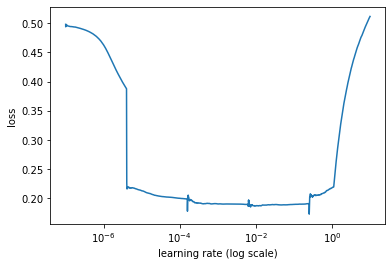

In [49]:
learner.lr_find(show_plot=True, max_epochs=5)

### Now let's train the model using the optimal learning rate. More accuracy is achieved after 4-5 epochs however to save time, we will run the cycle using 2 epochs only. That should give us ~93% accuracy and observed loss (binary crossentropy) of ~0.09

In [ ]:
learner.fit_onecycle(8e-3, 2)

##### Autofit function can help optimally train the model without ``overfitting`` it. **Do not run** unless you are willing to spend days (or perhaps weeks) on training

In [50]:
learner.autofit(5e-1)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.5...
Epoch 1/1024
29479/29479 [==============================] - 196s 7ms/step - loss: 0.2116 - accuracy: 0.9537 - val_loss: 0.1859 - val_accuracy: 0.9542
Epoch 2/1024
29479/29479 [==============================] - 198s 7ms/step - loss: 0.2110 - accuracy: 0.9537 - val_loss: 0.1861 - val_accuracy: 0.9542
Epoch 3/1024
29479/29479 [==============================] - 194s 7ms/step - loss: 0.2113 - accuracy: 0.9537 - val_loss: 0.1859 - val_accuracy: 0.9542

Epoch 00003: Reducing Max LR on Plateau: new max lr will be 0.25 (if not early_stopping).
Epoch 4/1024
29479/29479 [==============================] - 191s 6ms/step - loss: 0.1995 - accuracy: 0.9541 - val_loss: 0.1859 - val_accuracy: 0.9542
Epoch 5/1024
29479/29479 [==============================] - 199s 7ms/step - loss: 0.1999 - accuracy: 0.9540 - val_loss: 0.1859 

#### Alright, let's save our predictor so we can use it to perform inferences outside of the Jupyter notebook

In [32]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.save('detector_nbsvm')
print('MODEL SAVED')

MODEL SAVED


### It's time for some fun! First, get a predictor instance that uses our pre-trained model

In [ ]:
predictor = ktrain.load_predictor('detector_trained_1m')
new_model = ktrain.get_predictor(predictor.model, predictor.preproc)

#### Let's see if it can catch an XSS payload

In [ ]:
text = '<applet onkeydown="alert(1)" contenteditable>test</applet>'
result = new_model.predict(text)
print(result)

#### Now we can run more serious testing outside of the notebook